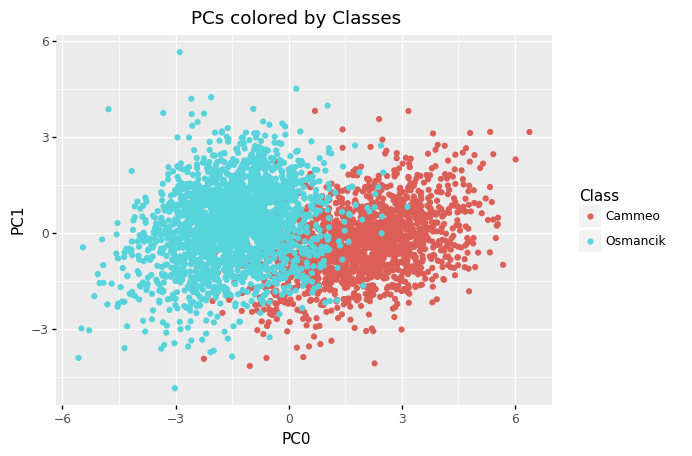

<ggplot: (126787661575)>

In [59]:
import pandas as pd
from sklearn import decomposition
import plotnine as p9

# examine the data
data = pd.read_excel('C:/Users/kryst/OneDrive/Desktop/Fall 1st/BIS 634/Rice_Osmancik_Cammeo_Dataset.xlsx')
data.iloc[:,0:-1] = data.iloc[:,0:-1].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
# separate out the features and classes
X = data.drop('CLASS', axis=1)
y = data['CLASS']
my_cols  = data.columns[:(len(data.columns)-1)]
    
# reduce the data to two dimensions using PCA
pca = decomposition.PCA(n_components=2)
data_reduced = pca.fit_transform(data[my_cols])
pc0 = data_reduced[:, 0]
pc1 = data_reduced[:, 1]
    
# plot a scatterplot of pc0 and pc1, color-coding by type of rice
    
(
    p9.ggplot(pd.DataFrame({
        'Class': y,
        'X': pc0,
        'Y': pc1
    }))
    + p9.geom_point(p9.aes(x="X", y="Y", color="Class"))
    + p9.labs(x="PC0", y="PC1")
    + p9.labels.ggtitle("PCs colored by Classes")
)

In [60]:
import heapq
import numpy as np
from sklearn import decomposition
from sklearn.model_selection import KFold
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

class QTNode():
    def __init__(self,ntype,xmin,xmax,ymin,ymax,
                 xmid=None,ymid=None,coord=None,cls=None,BRll=None,BRlh=None,BRhl=None,BRhh=None,parent=None):
        self.leaf=ntype  #0=non-leaf,1=leaf
        self.coord=coord #(x,y) coordinate
        self.cls=cls #classification
        self.nodecount=0 
        self.xmin=xmin
        self.xmax=xmax
        self.ymin=ymin
        self.ymax=ymax
        self.xmid=xmid
        self.ymid=ymid
        #the node's branches/quandrants
        self.BRll=BRll
        self.BRlh=BRlh
        self.BRhl=BRhl
        self.BRhh=BRhh
        self.parent=parent #parent branch

In [61]:
class QTree():
    def __init__(self,xmin,xmax,ymin,ymax):
        self.root=QTNode(1,xmin,xmax,ymin,ymax)

    def addnode(self,node,data):
        if len(data)==0:
            return
        elif len(data)==1:
            node.leaf=1 # is a leaf node
            node.coord=[data["PC0"].iloc[0],data["PC1"].iloc[0]] #the first item in "PC0" and "PC1" is the coordinate
            node.cls=data["CLASS"].iloc[0]
            node.nodecount=1
        else:
            node.leaf=0 # not a leaf node
            node.nodecount=len(data) 
            # subdivide based on x,y medians 
            node.xmid=np.median(data["PC0"])
            node.ymid=np.median(data["PC1"])
            node.BRll=QTNode(1,node.xmin,node.xmid,node.ymin,node.ymid,parent=node)
            node.BRlh=QTNode(1,node.xmin,node.xmid,node.ymid,node.ymax,parent=node)
            node.BRhl=QTNode(1,node.xmid,node.xmax,node.ymin,node.ymid,parent=node)
            node.BRhh=QTNode(1,node.xmid,node.xmax,node.ymid,node.ymax,parent=node)
            self.addnode(node.BRll,data[(data["PC0"]<node.xmid)&(data["PC1"]<node.ymid)])
            self.addnode(node.BRlh,data[(data["PC0"]<node.xmid)&(data["PC1"]>=node.ymid)])
            self.addnode(node.BRhl,data[(data["PC0"]>=node.xmid)&(data["PC1"]<node.ymid)])
            self.addnode(node.BRhh,data[(data["PC0"]>=node.xmid)&(data["PC1"]>=node.ymid)])
            if not node.BRll.nodecount:
                node.BRll=None
            if not node.BRlh.nodecount:
                node.BRlh=None
            if not node.BRhl.nodecount:
                node.BRhl=None
            if not node.BRhh.nodecount:
                node.BRhh=None

    def dist(self,p1,p2):
        return ((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5

    def naive_getneighbors(self,coord,k):
        neighbors=[]
        stack=[self.root]
        while stack:
            t=stack.pop(0) #take the topmost value of the stack as a target node
            if t.leaf: #if it is a leaf node
                dist=self.dist(t.coord,coord) #calculate the distance between the target coordinate and the coordinate added 
                #store as (priority, task) tuples, heapq will sort on the first element 
                heapq.heappush(neighbors,(-dist,t)) # https://codingdict.com/sources/py/heapq/7330.html
                if len(neighbors)>k: #if len of neightbors larger than k points
                    heapq.heappop(neighbors) #pop out the point with largest distances
            else:
                for child in [t.BRll,t.BRlh,t.BRhl,t.BRhh]: #if the target node has children
                    if child:
                        stack.append(child) #append its children of to the stack                       
        return neighbors

    def searchnode(self,coord,k=1):
        target=self.root
        last=None
        while target and not target.leaf:
            if target.nodecount<=k:
                return target
            if coord[0]<target.xmid:
                if coord[1]<target.ymid:
                    last=target
                    target=target.BRll
                else:
                    last=target
                    target=target.BRlh
            else:
                if coord[1]<target.ymid:
                    last=target
                    target=target.BRhl
                else:
                    last=target
                    target=target.BRhh
        return target if target else last

    def inrange(self,coord,node,dist):
        if coord[0]<node.xmin:
            if coord[1]<node.ymin:
                return self.dist(coord,(node.xmin,node.ymin))<=dist
            elif coord[1]>=node.ymax:
                return self.dist(coord,(node.xmin,node.ymax))<=dist
            else:
                return self.dist(coord,(node.xmin,coord[1]))<=dist
        elif coord[0]>=node.xmax:
            if coord[1]<node.ymin:
                return self.dist(coord,(node.xmax,node.ymin))<=dist
            elif coord[1]>=node.ymax:
                return self.dist(coord,(node.xmax,node.ymax))<=dist
            else:
                return self.dist(coord,(node.xmax,coord[1]))<=dist
        else:
            if coord[1]<node.ymin:
                return self.dist(coord,(coord[0],node.ymin))<=dist
            elif coord[1]>=node.ymax:
                return self.dist(coord,(coord[0],node.ymax))<=dist
            else:
                return True

    def getneighbors(self,coord,k):
        neighbors=[]
        target=self.searchnode(coord,k=k) 
        # here only focus the target branch(quadrant) that has the points of interest
        stack=[target]
        while stack:
            t=stack.pop(0) 
            if t.leaf:
                dist=self.dist(t.coord,coord)
                heapq.heappush(neighbors,(-dist,t))
            else:
                for child in [t.BRll,t.BRlh,t.BRhl,t.BRhh]:
                    if child:
                        stack.append(child)
        stack=[self.root]
        while stack:
            t=stack.pop(0)
            if t.leaf:
                dist=self.dist(t.coord,coord)
                heapq.heappush(neighbors,(-dist,t))
                if len(neighbors)>k:
                    heapq.heappop(neighbors)
            else:
                for child in [t.BRll,t.BRlh,t.BRhl,t.BRhh]: 
        # when the neighbors heap queue still have empty space, continue searching points in other branches
                    if child and child!=target and (len(neighbors)<k or self.inrange(coord,child,-neighbors[0][0])):
                        stack.append(child)
        return neighbors

When k = 1:
The confusion matrix of quad_tree knn method:
[[1411  195]
 [ 219 1985]]
The confusion matrix of naive knn method:
[[1411  195]
 [ 219 1985]]
Accuracy = 89.13%
Sensitivity = 86.56%
Specificity = 91.06%
Precision = 87.86%


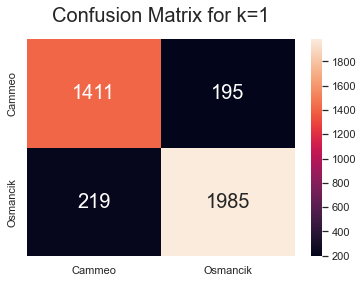

When k = 5:
The confusion matrix of quad_tree knn method:
[[1459  166]
 [ 171 2014]]
The confusion matrix of naive knn method:
[[1459  166]
 [ 171 2014]]
Accuracy = 91.15%
Sensitivity = 89.51%
Specificity = 92.39%
Precision = 89.78%


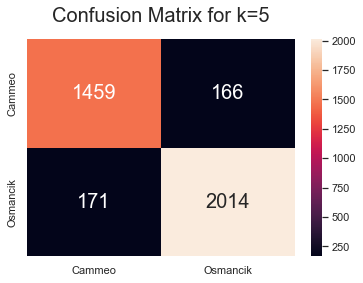

In [62]:
if __name__ == "__main__":
    # load the dataset
    data = pd.read_excel('C:/Users/kryst/OneDrive/Desktop/Fall 1st/BIS 634/Rice_Osmancik_Cammeo_Dataset.xlsx')
    data.iloc[:,0:-1] = data.iloc[:,0:-1].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

    X = data.drop('CLASS', axis=1)
    y = data['CLASS']
    my_cols  = data.columns[:(len(data.columns)-1)]
    
    for k in [1,5]:
        kf = KFold(n_splits=5,shuffle=True)
        X = data.drop('CLASS', axis=1)
        y = data['CLASS']
        pca = decomposition.PCA(n_components=2)
        my_cols  = data.columns[:(len(data.columns)-1)]

        pred_quad = []
        pred_naive = []
        true = []

        # implement 5-fold cross-validation         
        for train_index, test_index in kf.split(data):
            train_data=data.iloc[train_index]
            test_data=data.iloc[test_index]
            
            train_data_reduced = pca.fit_transform(train_data[my_cols])
            train_pc0 = train_data_reduced[:, 0]
            train_pc1 = train_data_reduced[:, 1]
            train = pd.DataFrame({'PC0': train_pc0, 'PC1': train_pc1, 'CLASS':train_data['CLASS']}, columns=['PC0', 'PC1', 'CLASS'])

            test_data_reduced = pca.transform(test_data[my_cols])
            test_pc0 = test_data_reduced[:, 0]
            test_pc1 = test_data_reduced[:, 1]
            test = pd.DataFrame({'PC0': test_pc0, 'PC1': test_pc1, 'CLASS':test_data['CLASS']}, columns=['PC0', 'PC1', 'CLASS'])

            datatree=QTree(min(train["PC0"]),max(train["PC0"]),min(train["PC1"]),max(train["PC1"]))
            datatree.addnode(datatree.root,train)

            # knn implementation
            for i,d in test.iterrows():
                res_quad = Counter([t[1].cls for t in datatree.getneighbors([d["PC0"],d["PC1"]],k)]).most_common(1)[0][0]
                res_naive = Counter([t[1].cls for t in datatree.getneighbors([d["PC0"],d["PC1"]],k)]).most_common(1)[0][0]
                
                pred_quad.append(res_quad)
                pred_naive.append(res_naive)

            true = true + test_data['CLASS'].to_list()

        # use the confusion matrix from sklearn to confirm the results
        print(f"When k = {k}:")
        print('The confusion matrix of quad_tree knn method:')
        print(confusion_matrix(pred_quad,true))
        print('The confusion matrix of naive knn method:')
        print(confusion_matrix(pred_naive,true))

        pred_labels = np.asarray(pred_quad)
        true_labels = np.asarray(true)

        # both Cammeo = true positive
        # both Osmancik = true negative

        # write our own confusion matrix 
        TP = np.sum(np.logical_and(true_labels == 'Cammeo', pred_labels == 'Cammeo'))
        TN = np.sum(np.logical_and(true_labels == 'Osmancik', pred_labels == 'Osmancik'))
        FP = np.sum(np.logical_and(true_labels == 'Osmancik', pred_labels == 'Cammeo')) 
        FN = np.sum(np.logical_and(true_labels == 'Cammeo', pred_labels == 'Osmancik'))

        accuracy = round((TP + TN) / (TP + FP + TN + FN) * 100, 2)
        sensitivity = round(TP / (TP + FN) * 100, 2)
        specificity = round(TN / (TN + FP) * 100, 2)
        precision = round(TP / (TP + FP) * 100, 2)

        print(f"Accuracy = {accuracy}%")
        print(f"Sensitivity = {sensitivity}%")
        print(f"Specificity = {specificity}%")
        print(f"Precision = {precision}%")

        # plot the confusion matrix 
        df_cm = pd.DataFrame({'Cammeo': [TP, FN],
                              'Osmancik': [FP, TN]},
                            index=['Cammeo', 'Osmancik'])

        plt.title(f"Confusion Matrix for k={k}", size=20, y=1.05)
        sn.set(font_scale= 1)
        sn.heatmap(df_cm, annot=True, annot_kws={'size': 20}, fmt='g')
        plt.show()   